In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.sql import label

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
max_date = session.query(func.max(Measurement.date)).scalar()
max_date

'2017-08-23'

In [10]:
# Design a query to retrieve the last 365 days of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
endate = dt.datetime.strptime(max_date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
startdate = endate - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
temps = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= startdate, Measurement.date <= endate).all()

# Save the query results as a Pandas DataFrame and sort DataFrame by date
temps_df = pd.DataFrame(temps).sort_values('date')

# Rename columns
temps_df = temps_df.rename(columns={'date':'Date','prcp':'Precipitation'})

# Set the index to the date column
temps_df = temps_df.set_index('Date')

# Drop NA
temps_df = temps_df.dropna()

temps_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


[Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-08-24'),
 Text(0, 0, '2016-08-24'),
 Text(0, 0, '2016-08-24'),
 Text(0, 0, '2016-08-24'),
 Text(0, 0, '2016-08-24')]

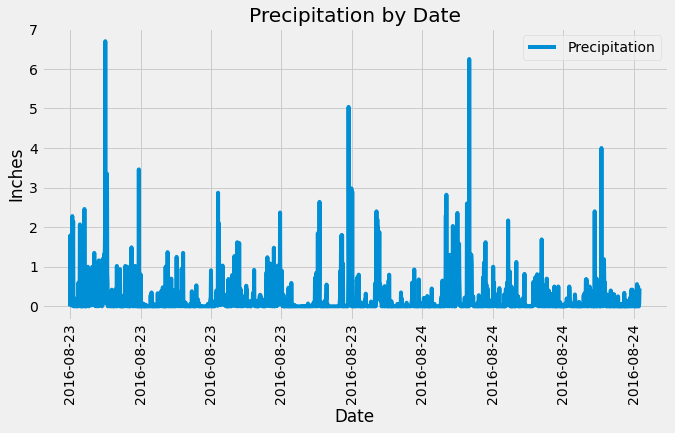

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
fig1 = temps_df.plot(figsize=(10,5), title='Precipitation by Date')
fig1.set_xlabel('Date')
fig1.set_ylabel('Inches')
fig1.set_xticklabels(temps_df.index,rotation=90)

In [12]:
# Summarize data
temps_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
station_ct = session.query(func.count(Station.station)).scalar()
station_ct

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
stations = session.query(Measurement.station, label('row_ct', func.count(Measurement.station))).group_by(Measurement.station).all()

# List the stations and the counts in descending order.
stations_df = pd.DataFrame(stations).sort_values('row_ct', ascending=False)
stations_df

,station,row_ct
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [15]:
# Find the most active station
top_station = stations_df['station'][stations_df['row_ct'] == stations_df['row_ct'].max()].item()

# Query the last 12 months of temperature observation data for this station
# Perform a query to retrieve the data and temp scores
temps = session.query(Measurement.date, Measurement.tobs
                       ).filter( Measurement.date >= startdate
                               , Measurement.date <= endate
                               , Measurement.station == top_station).all()

# Save the query results as a Pandas DataFrame and sort DataFrame by date
temps_df = pd.DataFrame(temps).sort_values('date')

# Rename columns
temps_df = temps_df.rename(columns={'date':'Date','tobs':'Temperature'})

# Set the index to the date column
temps_df = temps_df.set_index('Date')

# Drop NA
temps_df = temps_df.dropna()

temps_df.head()

,Temperature
Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


In [16]:
# Get the min, max, and average temperatures for the most active station
temp_summary = session.query(Measurement.station
                            ,label('Lowest Temp', func.min(Measurement.tobs))
                            ,label('Highest Temp', func.max(Measurement.tobs))
                            ,label('Average Temp', func.avg(Measurement.tobs))
                      ).filter( Measurement.station == top_station).group_by(Measurement.station).all()
temp_summary_df = pd.DataFrame(temp_summary).set_index('station')
temp_summary_df

,Lowest Temp,Highest Temp,Average Temp
station,,,
USC00519281,54.0,85.0,71.663781


Text(0.5, 0, 'Temperature')

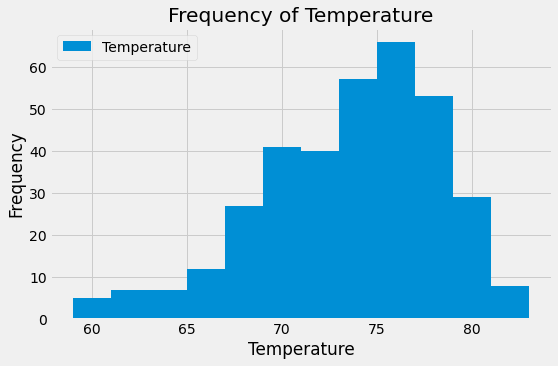

In [17]:
# Plot the results as a histogram
fig2 = temps_df.plot.hist(figsize=(8,5), title='Frequency of Temperature', bins=12)
fig2.set_xlabel('Temperature')


# Close session

In [18]:
# Close Session
session.close()